In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader,Dataset, random_split
from torchvision import utils

In [7]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import glob
from PIL import Image


In [8]:
# from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

In [9]:
import timm

In [10]:

import albumentations as A


In [11]:
from albumentations.pytorch import ToTensorV2

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split as TTS

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_and_labels_list, class_map,transform = None):
        
        self.data = img_paths_and_labels_list
        self.class_map = class_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.array(Image.open(img_path))

        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)

        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']

        return img, class_id


In [14]:
def img_paths_list(root_dir):
    root_list = glob.glob(root_dir)
    class_map = {}
    class_distribution = {}
    
    for img_path in root_list:
        class_name = img_path.split(os.sep)[-2]
        if class_name not in class_distribution:
            class_distribution[class_name] = 1
        else:
            class_distribution[class_name] +=1
                
    for index, entity in enumerate(class_distribution):
        class_map[entity] = index
    print("Dataset Distribution:\n")
    print(class_distribution)
    print("\n\nClass indices:\n")
    print(class_map)

    data = []
    for img_path in tqdm(root_list):
        class_name = img_path.split(os.sep)[-2]
        data.append([img_path, class_name])
        
    return data, class_map

In [15]:
train_root_dir = "input/corel-images/dataset/training_set/*/*"
train_dataset_img_paths_list, class_map = img_paths_list(train_root_dir)
print("\n"+"-"*150+"\n")
test_root_dir = "input/corel-images/dataset/test_set/*/*"
test_set_img_paths_list, _ = img_paths_list(test_root_dir)


Dataset Distribution:

{'beaches': 90, 'bus': 90, 'dinosaurs': 90, 'elephants': 90, 'flowers': 90, 'foods': 90, 'horses': 90, 'monuments': 90, 'mountains_and_snow': 90, 'peolpe_and_villages_in_Africa': 90}


Class indices:

{'beaches': 0, 'bus': 1, 'dinosaurs': 2, 'elephants': 3, 'flowers': 4, 'foods': 5, 'horses': 6, 'monuments': 7, 'mountains_and_snow': 8, 'peolpe_and_villages_in_Africa': 9}


  0%|          | 0/900 [00:00<?, ?it/s]


------------------------------------------------------------------------------------------------------------------------------------------------------

Dataset Distribution:

{'beaches': 10, 'bus': 10, 'dinosaurs': 10, 'elephants': 10, 'flowers': 10, 'foods': 10, 'horses': 10, 'monuments': 10, 'mountains_and_snow': 10, 'peolpe_and_villages_in_Africa': 10}


Class indices:

{'beaches': 0, 'bus': 1, 'dinosaurs': 2, 'elephants': 3, 'flowers': 4, 'foods': 5, 'horses': 6, 'monuments': 7, 'mountains_and_snow': 8, 'peolpe_and_villages_in_Africa': 9}


  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
def train_val_split(img_paths):
    X = []
    y = []
    for img_path in img_paths:
        X.append(img_path[0])
        y.append(img_path[1])
    
    X_train_list, X_val_list, y_train_list, y_val_list = TTS(X, y, stratify = y, test_size=0.20)
    
    train_img_paths = []
    val_img_paths = []
    for i in range(0, len(X_train_list)):
        train_img_paths.append([X_train_list[i], y_train_list[i]])
    for i in range(0, len(X_val_list)):
        val_img_paths.append([X_val_list[i], y_val_list[i]])
        
    return train_img_paths, val_img_paths

In [17]:
train_set_image_paths_list , val_set_image_paths_list = train_val_split(train_dataset_img_paths_list)
print(len(train_set_image_paths_list), len(val_set_image_paths_list), len(test_set_img_paths_list))

720 180 100


In [18]:
img_x = 224
img_y = 224

BS = 64

In [19]:
def transform_data(dataset = 'train'):
    if dataset == 'train':
        transforms = A.Compose(
            [
                A.Resize(img_x, img_y),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.3),
        #         A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                A.OneOf([
                    A.Blur(blur_limit=3, p=0.3),
                    A.ColorJitter(p=0.3),
                ], p=0.5),
                A.Normalize(
                    mean = (0.485, 0.456, 0.406),
                    std = (0.229, 0.224, 0.225),
                    max_pixel_value=255,
                ),
                ToTensorV2(),
            ]
        )
    elif dataset == 'test':
        transforms = A.Compose(
            [
        A.Resize(img_x, img_y),
        A.Normalize(
            mean = (0.485, 0.456, 0.406),
            std = (0.229, 0.224, 0.225),
            max_pixel_value=255,
        ),
        ToTensorV2(),
            ]
        )
        
    else:
        print("Set name invalid")
        
    return transforms
    

In [20]:
train_dataset = CustomDataset(train_set_image_paths_list, class_map, transform = transform_data("train"))
print(len(train_dataset))

val_dataset = CustomDataset(val_set_image_paths_list, class_map, transform = transform_data("test"))
print(len(val_dataset))

test_dataset = CustomDataset(test_set_img_paths_list, class_map, transform = transform_data("test"))
print(len(test_dataset))

720
180
100


In [21]:
train_loader = DataLoader(train_dataset, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BS, shuffle = False)
test_loader =  DataLoader(test_dataset, batch_size = BS, shuffle = False)

In [22]:
single_batch = next(iter(test_loader))
single_batch[0].shape

torch.Size([64, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


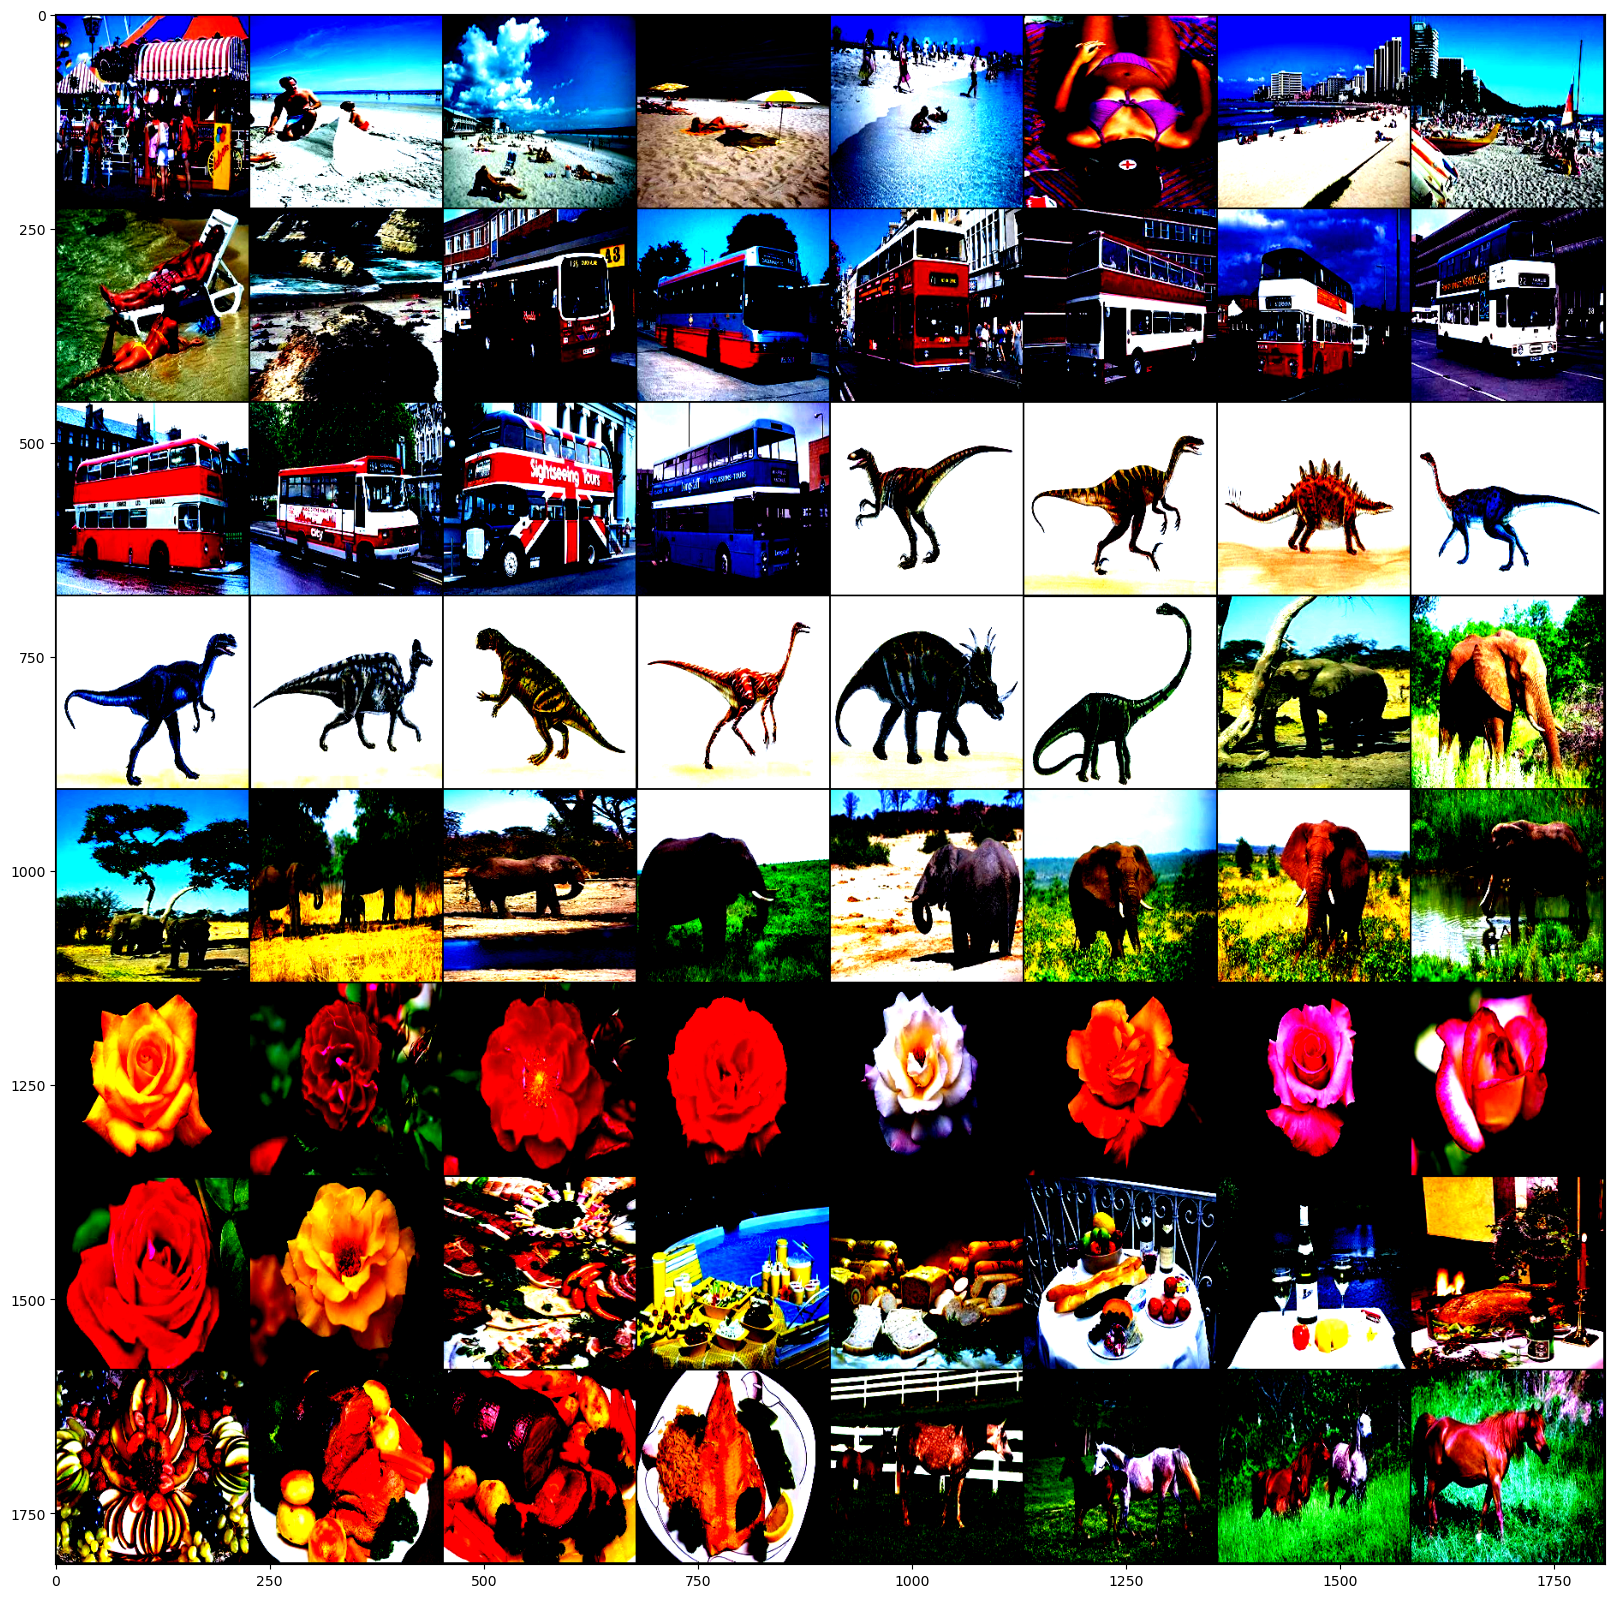

In [23]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


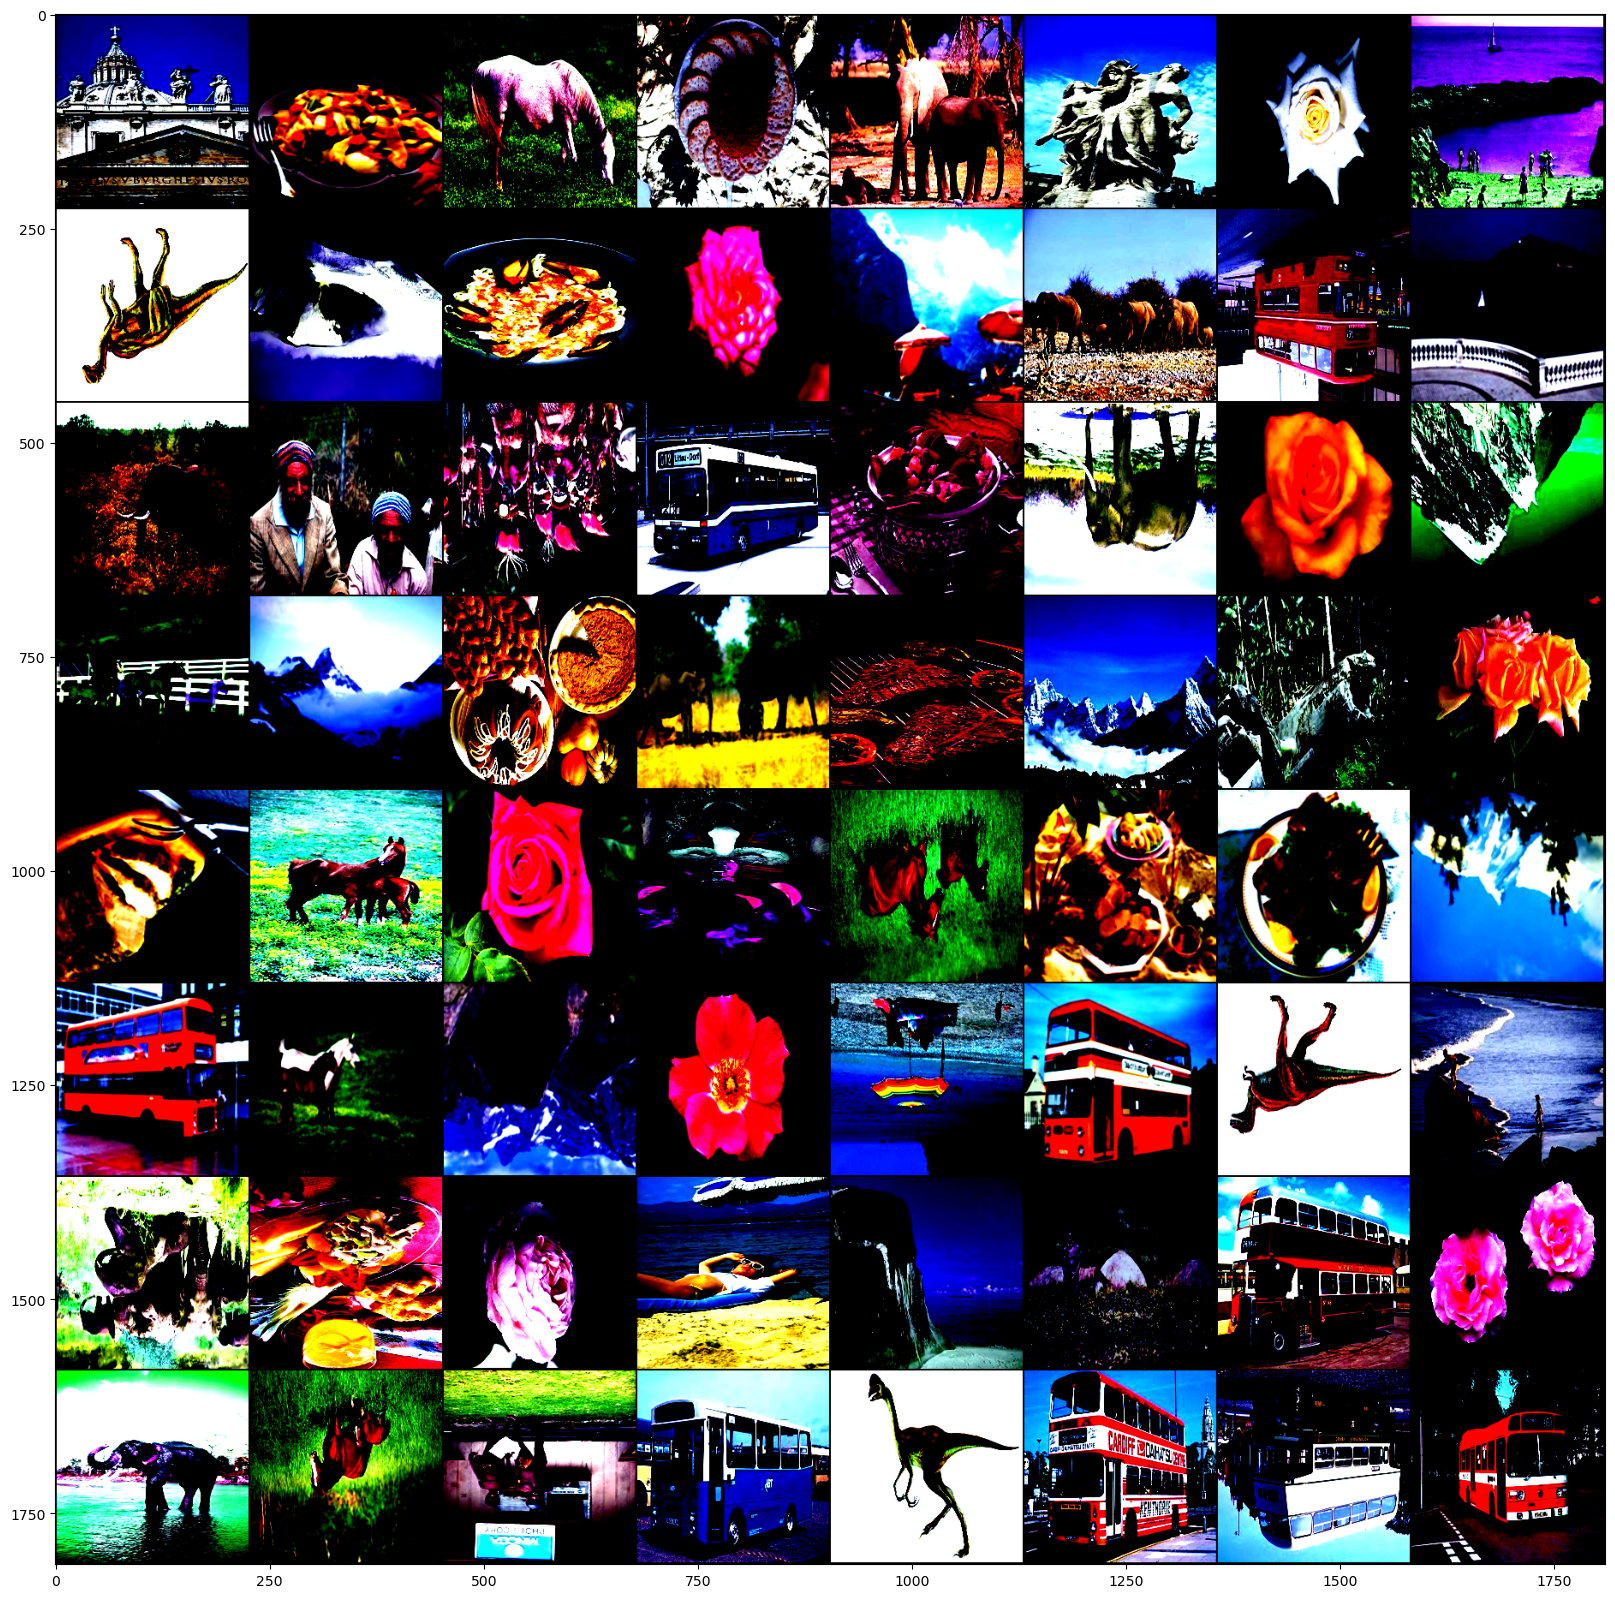

In [24]:
single_batch = next(iter(train_loader))
single_batch[0].shape

single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

## Modelling

In [25]:
import os
from torchvision import transforms       #transform ===> transforms
import torchvision.transforms as transforms

# import os
# from torchvision import transforms
# from torchvision.datasets import corel_images

In [28]:
# ##### INSTANTIATE MODEL

# # libraries
# # import torch
# # import torch.nn as nn

# # params
# model_name = 'efficientnet_b0'
# out_dim    = 10

# # instantiate
# model = timm.create_model('efficientnet_b0', pretrained = True)

# # adjust classifier
# model.classifier = nn.Linear(model.classifier.in_features, 
#                              out_dim)

# # load pre-trained weights 
# file_name = ''
# model.load_state_dict(torch.load(file_name))


# model = timm.create_model('efficientnet_b0',pretrained = True)
# model.default_cfg


AttributeError: module 'torch' has no attribute 'frombuffer'

In [29]:
model = timm.create_model('efficientnet_b0',pretrained = True)
model.default_cfg


AttributeError: module 'torch' has no attribute 'frombuffer'

In [30]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0',pretrained = pretrained)
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1280*7*7, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(1024, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128)
                                )
        self.head = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1280*7*7)
        features = self.fc(x)
        x = self.head(features)
        
        return features, x

In [ ]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc    

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []
    train_accuracy = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)[1]
        
        #loss and accuracy calculation
        loss = criterion(y_pred, y_truth)
        accuracy = calculate_accuracy(y_pred, y_truth)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss and accuracy
        # print(f'Partial train loss: {loss.data}')
        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(accuracy.detach().cpu().numpy())

    return model, np.mean(train_loss), np.mean(train_accuracy)

In [ ]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []
    val_accuracy = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)[1]

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            val_loss.append(loss.detach().cpu().numpy())
            val_accuracy.append(accuracy.detach().cpu().numpy())
            
    return np.mean(val_loss), np.mean(val_accuracy)
    

In [ ]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    acc_dict = {'train_accuracy':[],'val_accuracy':[]}
    
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0=10, T_mult=2,verbose=True)
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.3,verbose=True)


    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion)
        scheduler.step()

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)
        print(f'Train accuracy: {train_accuracy}, Val accuracy:{val_accuracy}')
        acc_dict['train_accuracy'].append(train_accuracy)
        acc_dict['val_accuracy'].append(val_accuracy)


    return model, loss_dict, acc_dict

In [ ]:
model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
EPOCHS = 20
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [ ]:
model, loss_dict, acc_dict = fit_model(model,criterion,optimizer)

In [ ]:
PATH = "effnetB0_finetuned_statedict.pth"
torch.save(model.state_dict(), PATH)
# PATH = "inception_resnetV2_finetuned.pth"
# torch.save(model, PATH)

In [ ]:
del model
gc.collect()

model = pre_trained_model().to(device)
model.load_state_dict(torch.load(PATH))

In [ ]:
 # Plot losses
plt.figure(figsize=(9,7))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
 # Plot accuracy
plt.figure(figsize=(9,7))
plt.semilogy(acc_dict['train_accuracy'], label='Train')
plt.semilogy(acc_dict['val_accuracy'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [ ]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    test_loss = []
    test_accuracy = []
    
    y_pred_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)[1]
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_labels.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            test_loss.append(loss.detach().cpu().numpy())
            test_accuracy.append(accuracy.detach().cpu().numpy())
            
    return y_pred_list, y_truth_list, np.mean(test_loss), np.mean(test_accuracy)

In [ ]:
y_pred_list, y_truth_list, test_loss, test_accuracy = test_epoch(model, test_loader, criterion)

print(test_loss, test_accuracy)

In [ ]:
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)
            
    return flattened_list

In [ ]:
y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)

In [ ]:
idx2class = {v: k for k, v in train_dataset.class_map.items()}
class_names = [i for i in train_dataset.class_map.keys()]
idx2class

In [ ]:
print(classification_report(y_truth_list_flattened, y_pred_list_flattened,target_names = class_names))

In [ ]:
print(confusion_matrix(y_pred_list_flattened, y_truth_list_flattened))

In [ ]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_truth_list_flattened, y_pred_list_flattened)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(19,12))         
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)